In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import itertools, random
from mbi import Dataset, FactoredInference, PublicInference, MixtureInference, LocalInference

In [2]:
data = Dataset.load('data.csv', 'domain.json')
total = data.df.shape[0]

In [3]:
display(data.df.head())

,TransAmtDisc,DayOfWeek,Hour,Product,CardType,CardCategory,EmailDomain,Region,DaysSinceLastTrans,isFraud
0,2,2,7,4,1,0,3,0,2,0
1,0,2,7,4,2,0,3,4,3,0
2,2,2,7,4,3,1,8,0,3,0
3,1,2,7,4,2,1,9,0,0,0
4,1,2,7,1,2,0,3,0,3,0


In [4]:
display(data.domain)

Domain(TransAmtDisc: 5, DayOfWeek: 7, Hour: 24, Product: 5, CardType: 4, CardCategory: 2, EmailDomain: 10, Region: 6, DaysSinceLastTrans: 4, isFraud: 2)

In [5]:
# SELECT the marginals we'd like to measure
cliques = [('DayOfWeek', 'Hour'),
('Product', 'CardCategory'),
('Product', 'CardType'),
('Product','DaysSinceLastTrans'),
('Product', 'EmailDomain'),
('Product', 'Region'),
('Product', 'isFraud'),
('TransAmtDisc','EmailDomain'),
('TransAmtDisc', 'Product'),
('TransAmtDisc', 'Region')]

In [6]:
# MEASURE the marginals and log the noisy answers
sigma = 50
measurements = []
for cl in cliques:
    x = data.project(cl).datavector()
    y = x + np.random.normal(loc=0, scale=sigma, size=x.shape)
    I = sparse.eye(x.size)
    measurements.append( (I, y, sigma, cl) )

In [7]:
# GENERATE synthetic data using Private-PGM 
engine = FactoredInference(data.domain, iters=2500)
model = engine.estimate(measurements)
synth = model.synthetic_data(rows = total)

In [8]:
# MEASURE the marginals and log the noisy answers
sigma = 50
printmsrmts = []
cl = ('Product', 'isFraud')
x = data.project(cl).datavector()
y = x + np.random.normal(loc=0, scale=sigma, size=x.shape)
z = synth.project(cl).datavector()
printmsrmts.append( (x, y, z) )
    
df = pd.DataFrame(np.concatenate(printmsrmts))
df.columns = ['P=1, F=0', 'P=1, F=1', 'P=2, F=0', 'P=2, F=1', 'P=3, F=0',
             'P=3, F=1', 'P=4, F=0', 'P=4, F=1', 'P=5, F=0', 'P=5, F=1']
df.index = ['Original Data', 'Noisy Data', 'Synthetic Data']

display(df)

,"P=1, F=0","P=1, F=1","P=2, F=0","P=2, F=1","P=3, F=0","P=3, F=1","P=4, F=0","P=4, F=1","P=5, F=0","P=5, F=1"
Original Data,9339.000000,1001.000000,15356.000000,302.000000,13926.000000,138.000000,2478.000000,60.000000,56342.000000,1058.00000
Noisy Data,9391.320618,1040.693116,15328.804163,340.846802,13972.238709,74.626392,2467.307433,137.789367,56435.680734,1066.64032
Synthetic Data,9329.000000,1002.000000,15381.000000,238.000000,13929.000000,168.000000,2578.000000,6.000000,56337.000000,1032.00000


Text(0, 0.5, '$L_1$ Error')

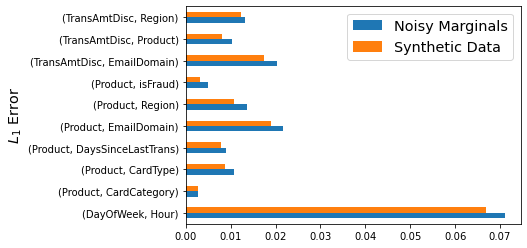

In [9]:
noisy_error = []
synth_error = []

for I, y, sigma, cl in measurements:
  z = synth.project(cl).datavector()
  x = data.project(cl).datavector()
  noisy_error.append(np.linalg.norm(x-y,1)/data.records)
  synth_error.append(np.linalg.norm(x-z,1)/data.records)
  #print(cl, np.linalg.norm(x-y,1)/data.records, np.linalg.norm(x-z,1)/data.records)

df = pd.DataFrame({'Noisy Marginals' : noisy_error, 'Synthetic Data': synth_error })
df.index = cliques
df.plot.barh()
plt.legend(fontsize='x-large')
plt.ylabel('$L_1$ Error', fontsize='x-large')

<ipython-input-10-012881f9edd5>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  cliques2 = random.sample(cliques2, 10)


Text(0, 0.5, '$L_1$ Error')

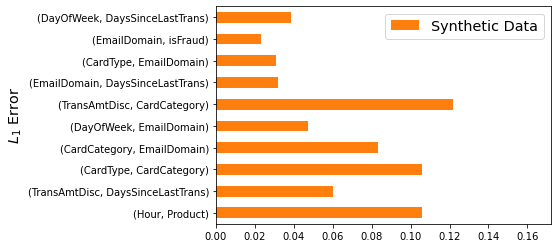

In [10]:
synth_error = []
cliques2 = set(itertools.combinations(data.domain, 2)) - set(cliques)
cliques2 = random.sample(cliques2, 10)

for cl in cliques2:
  x = data.project(cl).datavector()
  y = synth.project(cl).datavector()
  synth_error.append(np.linalg.norm(x-y,1)/data.records)
  #print(cl, np.linalg.norm(x-y,1)/data.records)

df = pd.DataFrame({'Synthetic Data' : synth_error})
df.index = cliques2
df.plot.barh(color='#ff7f0e')
plt.xlim(0,max(synth_error) + 0.05)
plt.legend(fontsize='x-large')
plt.ylabel('$L_1$ Error', fontsize='x-large')

In [11]:
# Evaluate the quality of the synthetic data on 2-way marginals
# Try modifying cliques above to see if you can reduce error!

def score(synth):
  errors = {}
  for cl in itertools.combinations(data.domain, 2):
    true_marginal = data.project(cl).datavector()
    est_marginal = synth.project(cl).datavector()
    errors[cl] = np.linalg.norm(true_marginal-est_marginal, 1) / data.records

  errors = pd.Series(errors).sort_values()

  print('Average Error', errors.mean(), '\n')
  return errors
  
display(score(synth))

Average Error 0.038733777777777784 



Product             CardCategory          0.00284
                    isFraud               0.00318
CardType            isFraud               0.00372
Region              isFraud               0.00492
Product             DaysSinceLastTrans    0.00778
TransAmtDisc        Product               0.00816
Product             CardType              0.00864
                    Region                0.01084
TransAmtDisc        isFraud               0.01106
DaysSinceLastTrans  isFraud               0.01136
CardType            DaysSinceLastTrans    0.01164
DayOfWeek           isFraud               0.01194
TransAmtDisc        Region                0.01236
CardCategory        isFraud               0.01568
DayOfWeek           CardType              0.01608
TransAmtDisc        EmailDomain           0.01752
Product             EmailDomain           0.01902
Hour                isFraud               0.02186
Region              DaysSinceLastTrans    0.02312
EmailDomain         isFraud               0.02328
